#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션

단계별로 나눠서 모델링을 수행하고자 합니다.  

* 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
* 단계2 : 세부 동작에 대한 분류모델 생성
    * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
    * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링 
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 모든 모델링은 [다양한 알고리즘 + 성능 튜닝]을 수행해야 합니다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [307]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [308]:
import joblib
data_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/data01_train.csv'
fi_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.12_미니프로젝트5차_3_5일차 실습자료/feature_importances.pkl'
data = pd.read_csv(data_path)
fi = joblib.load(fi_path)

In [309]:
data.drop('subject', axis=1, inplace=True)

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [310]:
is_dynamic = {
    'STANDING' : 0,
    'SITTING' : 0,
    'LAYING' : 0,
    'WALKING' : 1,
    'WALKING_UPSTAIRS' : 1,
    'WALKING_DOWNSTAIRS' : 1
}
data['Activity_dynamic'] = data['Activity'].replace(is_dynamic)

### *is_dynamic 구분에 사용할 Feature

<Axes: xlabel='feature_importance_dynamic', ylabel='feature_name'>

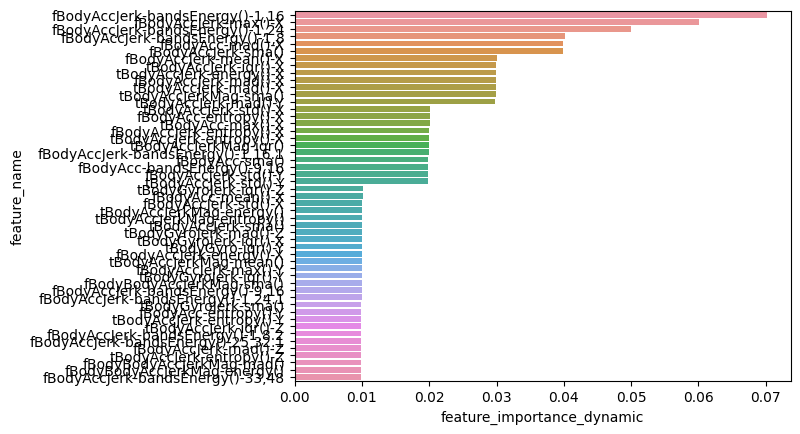

In [311]:
temp = fi.sort_values(by='feature_importance_dynamic', ascending=False)[['feature_name', 'feature_importance_dynamic']]
sns.barplot(x='feature_importance_dynamic', y='feature_name', data=temp[:51])

In [312]:
is_dynamic_features = temp[-2:]['feature_name'].values

### *Static Class 분류할 때 사용할 Feature

In [313]:
static_cols = ['feature_importance_standing', 'feature_importance_sitting', 'feature_importance_laying']
fi['feature_importance_static'] = fi[static_cols].mean(axis=1)

<Axes: xlabel='feature_importance_static', ylabel='feature_name'>

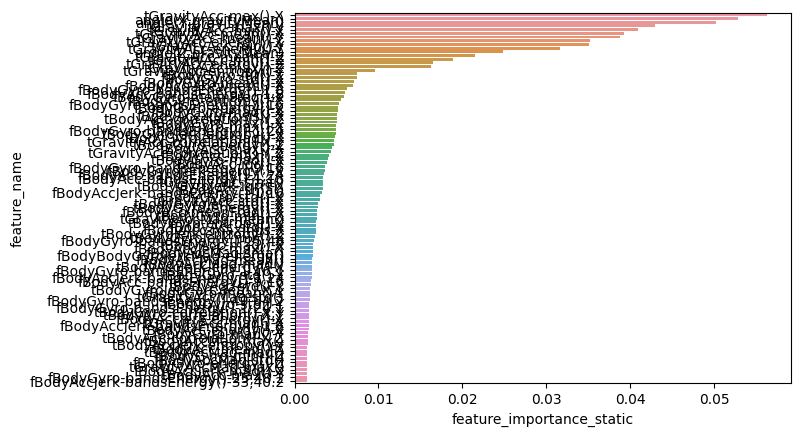

In [314]:
temp = fi.sort_values(by='feature_importance_static', ascending=False)[['feature_name', 'feature_importance_static']]
sns.barplot(x='feature_importance_static', y='feature_name', data=temp[:100])

In [315]:
static_features = temp[:]['feature_name'].values

### *Dynamic Class 분류에 사용할 Feature

In [316]:
dy_cols = ['feature_importance_walking', 'feature_importance_walking_up', 'feature_importance_walking_down']
fi['feature_importance_dy'] = fi[dy_cols].mean(axis=1)

<Axes: xlabel='feature_importance_dy', ylabel='feature_name'>

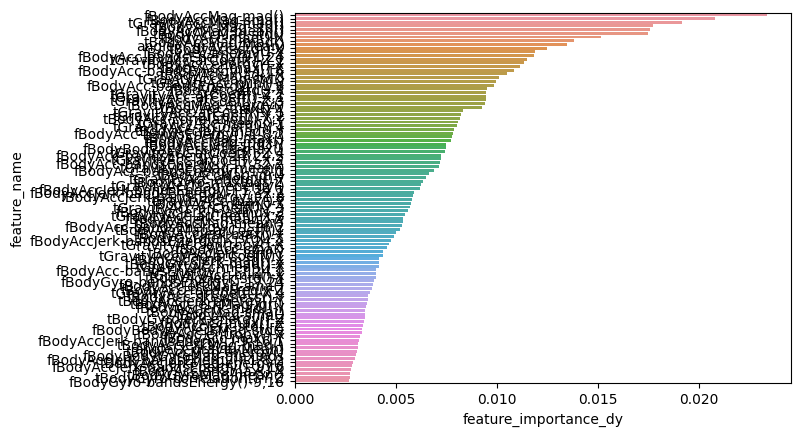

In [317]:
temp = fi.sort_values(by='feature_importance_dy', ascending=False)[['feature_name', 'feature_importance_dy']]
sns.barplot(x='feature_importance_dy', y='feature_name', data=temp[:100])

In [318]:
dynamic_features = temp[500:]['feature_name'].values

In [319]:
x = data.drop(columns=['Activity', 'Activity_dynamic'])
x = x[is_dynamic_features]
y = data.loc[:, 'Activity_dynamic']

In [320]:
x.shape

(5881, 2)

In [321]:
x_train_is, x_val_is, y_train_is, y_val_is = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

## **3.단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [322]:
model1 = LinearDiscriminantAnalysis()
model1.fit(x_train_is, y_train_is)

model1.score(x_val_is, y_val_is)

0.9796091758708582

In [323]:
y_pred = model1.predict(x_val_is)
print(confusion_matrix(y_val_is, y_pred))
print(classification_report(y_val_is, y_pred))

[[640   7]
 [ 17 513]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       647
           1       0.99      0.97      0.98       530

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [324]:
static_data = data[data['Activity_dynamic'] == 0].reset_index(drop=True)
x_static = static_data.drop(columns=['Activity', 'Activity_dynamic'])
x_static = x_static[static_features]
y_static = static_data['Activity']

x_train_static, x_val_static, y_train_static, y_val_static = train_test_split(
    x_static, y_static, test_size=0.2, random_state=42, stratify=y_static
)

In [325]:
# static 분류 모델
model2_1 = LogisticRegression(max_iter=1000)
model2_1.fit(x_train_static, y_train_static)

model2_1.score(x_val_static, y_val_static)

0.9829984544049459

In [326]:
y_pred = model2_1.predict(x_val_static)
print(confusion_matrix(y_val_static, y_pred))
print(classification_report(y_val_static, y_pred))

[[223   0   0]
 [  1 201   4]
 [  0   6 212]]
              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00       223
     SITTING       0.97      0.98      0.97       206
    STANDING       0.98      0.97      0.98       218

    accuracy                           0.98       647
   macro avg       0.98      0.98      0.98       647
weighted avg       0.98      0.98      0.98       647



### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [327]:
dy_data = data[data['Activity_dynamic'] == 1].reset_index(drop=True)
x_dy = dy_data.drop(columns=['Activity', 'Activity_dynamic'])
x_dy = x_dy[dynamic_features]
y_dy = dy_data['Activity']

x_train_dy, x_val_dy, y_train_dy, y_val_dy = train_test_split(
    x_dy, y_dy, test_size=0.2, random_state=42, stratify=y_dy
)

In [328]:
# dynamic 분류 모델
model2_2 = LinearDiscriminantAnalysis()
model2_2.fit(x_train_dy, y_train_dy)

model2_2.score(x_val_dy, y_val_dy)

0.7905660377358491

In [329]:
y_pred = model2_2.predict(x_val_dy)
print(confusion_matrix(y_val_dy, y_pred))
print(classification_report(y_val_dy, y_pred))

[[166  12  22]
 [ 29 116  13]
 [ 24  11 137]]
                    precision    recall  f1-score   support

           WALKING       0.76      0.83      0.79       200
WALKING_DOWNSTAIRS       0.83      0.73      0.78       158
  WALKING_UPSTAIRS       0.80      0.80      0.80       172

          accuracy                           0.79       530
         macro avg       0.80      0.79      0.79       530
      weighted avg       0.79      0.79      0.79       530



### (4) 분류 모델 합치기


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [330]:
def my_model_predict(x):
    """
    params:
        x : DataFrame. Features
    ret:
        y_pred : numpy array

    model1 : 정적 동적 구분 (LDA 모델 사용 (LinearDiscriminantAnalysis))
    model2-1 : 정적으로 구분한 것을 세부 Class 분류 (Logistic Regression 모델 사용)
    model2-1 : 동적으로 구분한 것을 세부 Class 분류 (LDA 모델 사용 (LinearDiscriminantAnalysis))
    """
    # 정적, 동적 예측 결과 저장
    is_dynamic_input = x[is_dynamic_features]
    x['is_dynamic'] = model1.predict(is_dynamic_input)

    # 정적과 동적 예측 결과에 따라 나누기
    # reset_index로 원래의 index 를 column으로 빼서 나중에 concat 후 사용
    temp_static = x[x['is_dynamic'] == 0].reset_index()
    temp_dynamic = x[x['is_dynamic'] == 1].reset_index()

    static_input = temp_static[static_features]
    dynamic_input = temp_dynamic[dynamic_features]

    # 정적, 동적 별로 각 Class 예측
    temp_static['label'] = model2_1.predict( static_input )
    temp_dynamic['label'] = model2_2.predict( dynamic_input )

    # 각 예측 결과를 합치고, index로 정렬
    result_df = pd.concat([temp_static, temp_dynamic], axis=0).sort_values(by='index').set_index('index')

    # y_pred 뽑기
    y_pred = result_df['label'].values

    return y_pred

In [331]:
y_pred = my_model_predict(data.drop(['Activity', 'Activity_dynamic'], axis=1))
y = data['Activity'].values
print(f"Accuracy Score : {accuracy_score(y, y_pred)}")
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

Accuracy Score : 0.8944057133140623
[[1101    0    0    3    0   11]
 [   1 1004   21    2    0    4]
 [   0   24 1052    8    0    3]
 [   0    5   67  800   47   79]
 [   0    0    1  109  611   70]
 [   0    3   22   91   50  692]]
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      0.99      1115
           SITTING       0.97      0.97      0.97      1032
          STANDING       0.90      0.97      0.94      1087
           WALKING       0.79      0.80      0.80       998
WALKING_DOWNSTAIRS       0.86      0.77      0.82       791
  WALKING_UPSTAIRS       0.81      0.81      0.81       858

          accuracy                           0.89      5881
         macro avg       0.89      0.88      0.89      5881
      weighted avg       0.89      0.89      0.89      5881

